# Random Forest - Classification Step 2 (Balancing dataset with SMOTE)

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# importing dataset
ids_dataset = pd.read_csv("IDS_merged_dataset.csv")
ids_dataset.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_5500\1319772336.py:2: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  ids_dataset = pd.read_csv("IDS_merged_dataset.csv")


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,4.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.5-8.254.250.126-49188-80-6,8.254.250.126,80.0,192.168.10.5,49188.0,6.0,03/07/2017 08:55:58,1.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.14-8.253.185.121-49486-80-6,8.253.185.121,80.0,192.168.10.14,49486.0,6.0,03/07/2017 08:56:22,3.0,2.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
# Classes
ids_dataset[' Label'].unique()

array(['BENIGN', 'FTP-Patator', 'SSH-Patator', 'DoS slowloris',
       'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye', 'Heartbleed',
       'Infiltration', 'Web Attack – Brute Force', 'Web Attack – XSS',
       'Web Attack – Sql Injection', nan, 'Bot', 'DDoS', 'PortScan'],
      dtype=object)

In [4]:
# filtering dataset;- selecting only BEGNIN records
# ids_dataset = ids_dataset[ids_dataset[' Label'] == 'BENIGN']
# ids_dataset.head()

In [5]:
ids_dataset.shape

(3119345, 85)

In [6]:
# dataset information
# ids_dataset.info()

In [7]:
# Dataset columns
# ids_dataset.columns

In [8]:
# # dropping unwanted columns
# columns_to_be_dropped = [
#     'Flow ID', 
#     ' Source IP', 
#     ' Source Port',
#     ' Destination IP', 
#     ' Destination Port', 
#     ' Protocol',
#     ' Timestamp',
#     ' Label'
# ]

# pre_pca_ids_dataset = ids_dataset.drop(columns_to_be_dropped, axis=1)
# pre_pca_ids_dataset.head()

In [9]:
selected_features = [' Bwd Packet Length Std', ' Packet Length Variance',
       'Init_Win_bytes_forward', 'Bwd Packet Length Max',
       ' Average Packet Size', ' Packet Length Std',
       ' Packet Length Mean', ' Bwd Packet Length Mean', ' Label']
selected_dataset = ids_dataset[selected_features].copy()
selected_dataset.head()

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean,Label
0,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0,BENIGN
1,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0,BENIGN
2,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0,BENIGN
3,0.0,0.0,329.0,0.0,9.0,0.0,6.0,0.0,BENIGN
4,0.0,0.0,245.0,0.0,9.0,0.0,6.0,0.0,BENIGN


In [10]:
# 5 summary of dataset
selected_dataset.describe()

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,3.353257e+02,4.861548e+05,6.989837e+03,8.708495e+02,1.919837e+02,2.949756e+02,1.719444e+02,3.059493e+02
std,8.396932e+02,1.647490e+06,1.433873e+04,1.946367e+03,3.318603e+02,6.318001e+02,3.054915e+02,6.052568e+02
min,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,7.500000e+00,0.000000e+00,6.000000e+00,0.000000e+00
50%,0.000000e+00,6.750000e+02,2.510000e+02,7.900000e+01,7.225000e+01,2.598076e+01,5.720000e+01,7.200000e+01
75%,7.794054e+01,3.038884e+04,8.192000e+03,2.800000e+02,1.492639e+02,1.743239e+02,1.198000e+02,1.810000e+02
max,8.194660e+03,2.240000e+07,6.553500e+04,1.953000e+04,3.893333e+03,4.731522e+03,3.337143e+03,5.800500e+03


In [11]:
selected_dataset.shape

(3119345, 9)

In [12]:
# Dropping missing values
selected_dataset.dropna(inplace=True)

In [13]:
selected_dataset.shape

(2830743, 9)

In [14]:
# Converting infinity to nan
selected_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
# Dropping na
selected_dataset.dropna(inplace=True)

In [16]:
selected_dataset.shape

(2830743, 9)

# generating synthetic samples

In [21]:
malicious_dataset = selected_dataset[ selected_dataset[' Label'] != 'BENIGN']

In [20]:
# smote object
smote = SMOTE(random_state=42, )

In [24]:
X = malicious_dataset.drop(' Label', axis=1)
y = malicious_dataset[' Label']

In [25]:
new_X, new_y = smote.fit_resample(X, y)

In [35]:
new_X[' Label'] = new_y

In [33]:
new_y.value_counts()

FTP-Patator                   231073
SSH-Patator                   231073
DoS slowloris                 231073
DoS Slowhttptest              231073
DoS Hulk                      231073
DoS GoldenEye                 231073
Heartbleed                    231073
Infiltration                  231073
Web Attack – Brute Force      231073
Web Attack – XSS              231073
Web Attack – Sql Injection    231073
Bot                           231073
DDoS                          231073
PortScan                      231073
Name:  Label, dtype: int64

In [34]:
malicious_dataset[' Label'].value_counts()

DoS Hulk                      231073
PortScan                      158930
DDoS                          128027
DoS GoldenEye                  10293
FTP-Patator                     7938
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1966
Web Attack – Brute Force        1507
Web Attack – XSS                 652
Infiltration                      36
Web Attack – Sql Injection        21
Heartbleed                        11
Name:  Label, dtype: int64

In [36]:
new_X.columns

Index([' Bwd Packet Length Std', ' Packet Length Variance',
       'Init_Win_bytes_forward', 'Bwd Packet Length Max',
       ' Average Packet Size', ' Packet Length Std', ' Packet Length Mean',
       ' Bwd Packet Length Mean', ' Label'],
      dtype='object')

In [37]:
malicious_dataset.columns

Index([' Bwd Packet Length Std', ' Packet Length Variance',
       'Init_Win_bytes_forward', 'Bwd Packet Length Max',
       ' Average Packet Size', ' Packet Length Std', ' Packet Length Mean',
       ' Bwd Packet Length Mean', ' Label'],
      dtype='object')

# Combining synthetic with original

In [41]:
combined_malicious_dataset = pd.concat([malicious_dataset, new_X])

In [42]:
combined_malicious_dataset

,Bwd Packet Length Std,Packet Length Variance,Init_Win_bytes_forward,Bwd Packet Length Max,Average Packet Size,Packet Length Std,Packet Length Mean,Bwd Packet Length Mean,Label
541265,0.0,0.0,29200.0,0.0,0.0,0.0,0.0,0.0,FTP-Patator
541266,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,FTP-Patator
541267,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,FTP-Patator
541268,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,FTP-Patator
541269,0.0,0.0,229.0,0.0,0.0,0.0,0.0,0.0,FTP-Patator
...,...,...,...,...,...,...,...,...,...
3235017,0.0,0.0,29200.0,0.0,0.0,0.0,0.0,0.0,Web Attack – XSS
3235018,0.0,0.0,29200.0,0.0,0.0,0.0,0.0,0.0,Web Attack – XSS
3235019,0.0,0.0,29200.0,0.0,0.0,0.0,0.0,0.0,Web Attack – XSS
3235020,0.0,0.0,29200.0,0.0,0.0,0.0,0.0,0.0,Web Attack – XSS


In [44]:
malicious_dataset.shape[0] + new_X.shape[0]

3792668

In [46]:
selected_dataset[selected_dataset[' Label'] == 'BENIGN'].shape[0]

2273097

In [48]:
# Combining malicious and benign
combined_dataset = pd.concat([selected_dataset, new_X])

<AxesSubplot: >

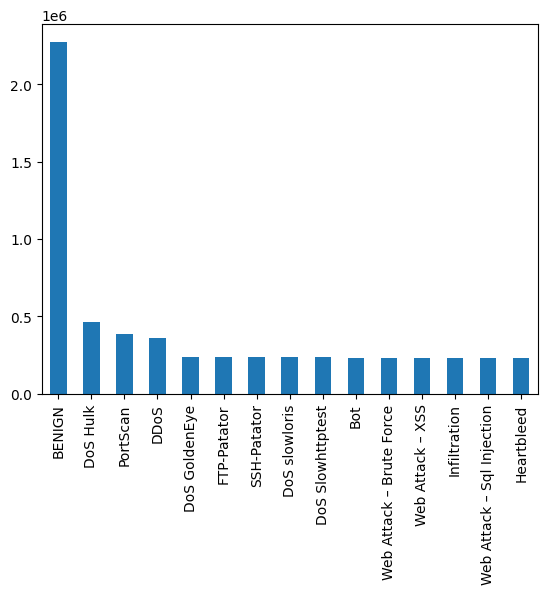

In [52]:
combined_dataset[' Label'].value_counts().plot(kind='bar')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    combined_dataset.drop(' Label', axis=1), 
    combined_dataset[' Label'],
    test_size=0.2,
    random_state=42)

In [54]:
# random forest object
rf_model = RandomForestClassifier()

In [55]:
# fitting model
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [57]:
y_pred = rf_model.predict(X_test)

In [58]:
pd.DataFrame(confusion_matrix(y_test, y_pred))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,448116,656,7,150,1313,28,1,13,0,10,308,110,927,221,3359
1,578,45827,0,0,0,0,0,0,0,0,0,0,7,0,0
2,122,0,71791,0,0,0,0,0,0,0,0,0,0,0,0
3,392,0,0,47745,0,1,1,0,0,0,0,0,0,0,1
4,145,0,0,97,91851,0,0,0,0,0,0,0,0,0,46
5,104,0,0,0,0,22734,214,183,0,0,0,0,0,9,24301
6,94,0,0,0,0,0,34081,0,0,0,0,0,0,4,13309
7,177,0,0,0,0,0,0,47508,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,46406,0,0,0,0,0,0
9,76,0,0,0,0,0,0,0,0,46278,0,0,0,0,0


In [59]:
accuracy_score(y_test, y_pred)

0.929100451468199

In [62]:
print(classification_report(y_test, y_pred))

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.98      0.99    455219
                       Bot       0.99      0.99      0.99     46412
                      DDoS       1.00      1.00      1.00     71913
             DoS GoldenEye       0.99      0.99      0.99     48140
                  DoS Hulk       0.99      1.00      0.99     92139
          DoS Slowhttptest       1.00      0.48      0.65     47545
             DoS slowloris       0.99      0.72      0.83     47488
               FTP-Patator       1.00      1.00      1.00     47686
                Heartbleed       1.00      1.00      1.00     46406
              Infiltration       1.00      1.00      1.00     46354
                  PortScan       1.00      1.00      1.00     78145
               SSH-Patator       1.00      1.00      1.00     47215
  Web Attack – Brute Force       0.83      0.19      0.31     46191
Web Attack – Sql Injection       0.99      0.98